### Závěrečný projekt - modul Python

V tomto projektu budete analyzovat data ze stránky `www.sreality.cz`. Budete tedy získávat aktuální nabídku bytů ve Zlíně (či ve městě dle vašeho výběru)

## Důležité poznámky před začátkem:
- Mezi requesty vkládejte krátké pauzy (např. pomocí `time.sleep(1-2)`), abyste nezatěžovali server.
- **Struktura notebooku**: Váš notebook by měl být přehledně strukturovaný pomocí markdown buněk s nadpisy a komentářů v kódu, které vysvětlují vaše kroky.

## Projekt se dělí na 3 části:

### 1. WebScraping
Pomocí knihovny `BeautifulSoup` získejte **všechny aktuální inzerce bytů** v daném městě. 

**Poznámky:**
- Web scraping musí zahrnovat **všechny stránky** výsledků (pagination), ne pouze první stránku
- Získáte **tyto** informace: 
  - `URL odkaz bytu`
  - `Rozměry bytu` (v m²)
  - `Dispozice bytu` (1+1, 2+kk, atp.)
  - `Cena bytu` (v Kč)
  - `Lokace bytu` (Ulice + město)

**Očekávaný formát dat:**
- **Uložte surová data do CSV souboru** s názvem `{vašeJméno}_surova_data.csv` (tento soubor použijete v další části)

### 2. Datová analýza - ETL proces (Extract, Transform, Load)
V této fázi prověďte processing dat tak, aby obsahovala příslušné datové typy a byla připravená pro analýzu.

**Úkoly:**
- **Načtení dat:**
  - Načtěte surová data z CSV souboru `{vašeJméno}_surova_data.csv`, který jste vytvořili v části 1
  - Zobrazte základní informace o načtených datech (počet řádků, sloupců, náhled dat, datové typy)
  
- **Čištění dat:**
  - Ověřte a opravte datové typy (cena jako číselný typ, rozměry jako číselný typ)
  - Zpracujte chybějící hodnoty (rozhodněte se, zda je odstranit nebo nahradit, a zdůvodněte)
  - Rozdělte lokaci na samostatné sloupce: `Ulice` a `Město`
  
- **Export dat:**
  - Zprocesovaná a vyčištěná data vyexportujte do `.csv` souboru s názvem `{vašeJméno}_zdrojová_data.csv`
  - Před exportem zobrazte základní statistiku o vyčištěných datech (počet řádků, sloupců, základní statistiky)

### 3. Datová analýza - analýza dat
Třetí část začněte tak, že si do dataframe nahrajete vyčištěná data z CSV souboru `{vašeJméno}_zdrojová_data.csv`, který jste vytvořili v části 2.

**Analytické dotazy:**
1. `Jaká je průměrná cena bytů?` (uveďte i medián pro srovnání)
2. `Jaká je průměrná cena bytů pro každou dispozici (1+1, 2+1, atp.)? Zobrazte i na grafu.`
3. `Jaká je průměrná velikost bytu pro každou dispozici? Zobrazte i na grafu.`
4. `Existuje ulice, kde je vyšší koncentrace dražších bytů?` (Definujte "dražší" jako byty nad průměrnou cenou. Zobrazte top 5 ulic s nejvyšší průměrnou cenou, pokud máte dostatek dat.)
5. `Jaký typ dispozice je v daném městě nejčastěji inzerován? Který to je? Proč myslíte, že tomu tak je?` (Zobrazte na grafu - např. bar chart nebo pie chart)
6. `Existují zde inzerce bytů, které stojí více než 20.000,- Kč? Pokud ano, jsou v této cenové hladině inzerovány i maximálně dvoupokojové byty (2+1/2+kk)?`
7. `Zjištěte minimální a maximální cenu inzerce pro každou dispozici bytu. Která dispozice má největší rozptyl mezi minimální a maximální inzerovanou cenou?` (Zobrazte i na grafu)

**Poznámky k analýze:**
- Všechny odpovědi doplňte komentáři a interpretací výsledků
- Pro vizualizace použijte `matplotlib` nebo `seaborn`
- Grafy by měly mít popisky os, titulky a být čitelné

## Odevzdání:
- Dotazy zodpovězte ve vašem pracovním notebooku s komentáři a interpretacemi
- Výsledný soubor nahrajte na GitHub
- V README na GitHubu uveďte stručný popis projektu a hlavní zjištění

## Tipy a užitečné knihovny

**Doporučené knihovny:**
```python
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
```

**Užitečné tipy:**
- Pro pagination: Zkontrolujte, jak stránka implementuje stránkování (URL parametr `?strana=X` nebo jiný mechanismus)
- Pro čištění dat: `pd.to_numeric()` s parametrem `errors='coerce'` pro konverzi cen a rozměrů
- Pro rozdělení lokace: `str.split()`

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re

In [3]:
import re
import time
import requests
from bs4 import BeautifulSoup

strana = 1
byty = []
dalsi_strana = True

while dalsi_strana:

    response = requests.get(
        f"https://www.sreality.cz/hledani/pronajem/byty/zlin?strana={strana}"
    ).text

    soup = BeautifulSoup(response, "html.parser")
    ul = soup.find("ul", attrs={"data-e2e": "estates-list"})  # najdu seznam nabidek
    if not ul:
        print("Nenasel jsem seznam nabidek, koncim ...")
        break

    karty = ul.find_all("li", recursive=False)  # najdu vsechny "karty" bytů
    pridano = 0  # kolik bytu se pridalo na teto strane

    for karta in karty:
        a = karta.find(
            "a", href=re.compile(r"^/detail/pronajem/byt/")
        )  # odkaz na detail
        if not a:
            continue  # ignoruji, pokud odkaz neni nalezen (reklamy apod.)

        url = "https://www.sreality.cz" + a["href"]  # kompletni URL

        p_class = a.find_all("p")  # najdu vsechny p v karte

        titulek = p_class[0].get_text().strip()  # titulek je prvni p
        lokalita = p_class[1].get_text().strip()  # lokalita je druhe p
        cena_txt = p_class[2].get_text().strip()  # cena je treti p

        # vytahnu dispozici z titulku
        m_dispo = re.search(r"\b\d+\s*\+\s*(?:kk|\d+)\b", titulek)
        dispozice = m_dispo.group(0) if m_dispo else None

        # rozmer z titulku a jeste prevedu na int
        m_rozmer = re.search(r"(\d+)\s*m²", titulek)
        rozmer = int(m_rozmer.group(1)) if m_rozmer else None

        # ulozim cenu jako int a pokud neni nalezena, tak None
        m = re.search(r"([\d\s]+)\s*Kč", cena_txt)
        cena = int(re.sub(r"\s+", "", m.group(1))) if m else None

        # ulozim data do slovniku
        byt = {
            "url": url,
            "rozmer": rozmer,
            "dispozice": dispozice,
            "cena": cena,
            "lokalita": lokalita,
        }
        byty.append(byt)
        pridano += 1

    # kontrola, kolik bytu se pridalo na teto strane
    if pridano == 0:  # pokud se nepridal zadny byt, koncim
        dalsi_strana = False
    else:
        strana += 1  # inkrementuju stranku az po zpracovani cele stranky
        time.sleep(0.5)  # pauza mezi pozadavky

In [4]:
# uložení dat to csv
df = pd.DataFrame(byty)
df.to_csv("Petrysak_surova_data.csv", index=False)

### Načtení dat


In [5]:
# načtení surových dat
df = pd.read_csv("Petrysak_surova_data.csv")

# počet řádků a sloupců
pocet_radku_pred, pocet_sloupcu_pred = df.shape
print(f"Počet řádků: {pocet_radku_pred}, Počet sloupců: {pocet_sloupcu_pred}")

# datové typy jednotlivých sloupců
print("\nDatové typy jednotlivých sloupců:")
print(df.dtypes)
df

Počet řádků: 219, Počet sloupců: 5

Datové typy jednotlivých sloupců:
url           object
rozmer         int64
dispozice     object
cena         float64
lokalita      object
dtype: object


,url,rozmer,dispozice,cena,lokalita
0,https://www.sreality.cz/detail/pronajem/byt/1+...,33,1+kk,13500.0,"Nad Stráněmi, Zlín"
1,https://www.sreality.cz/detail/pronajem/byt/2+...,51,2+kk,14500.0,"Kúty, Zlín"
2,https://www.sreality.cz/detail/pronajem/byt/2+...,60,2+1,16000.0,"třída Tomáše Bati, Zlín"
3,https://www.sreality.cz/detail/pronajem/byt/2+...,56,2+1,13000.0,"Dlouhá, Zlín"
4,https://www.sreality.cz/detail/pronajem/byt/1+...,28,1+kk,10000.0,"Nad Stráněmi, Zlín"
...,...,...,...,...,...
214,https://www.sreality.cz/detail/pronajem/byt/2+...,78,2+1,15000.0,"Lešenská, Zlín - Kostelec"
215,https://www.sreality.cz/detail/pronajem/byt/1+...,35,1+1,11000.0,Lípa
216,https://www.sreality.cz/detail/pronajem/byt/3+...,143,3+kk,33000.0,"Nad Stráněmi, Zlín"
217,https://www.sreality.cz/detail/pronajem/byt/1+...,23,1+kk,10000.0,"Leoše Janáčka, Luhačovice"


### Čištění dat

In [6]:
# převod url na string
df["url"] = df["url"].astype("string")

# převod dispozice na string
df["dispozice"] = df["dispozice"].astype("string")

# převod lokalita na string
df["lokalita"] = df["lokalita"].astype("string")

# {*** zobrazení řádků, kde něco chybí (pro rychlou kontrolu) ***}
df_missing_rows = df[df.isna().any(axis=1)]

# byly nalezeny ceny s hodnotou NaN. Tyto řádky smažu, jelikož by mi velmi ovlivnily analýzu
df = df.dropna(subset=["cena"]).copy()
df = df.reset_index(drop=True)

# převod cena na int
df["cena"] = df["cena"].astype("int64")

# rozdělím lokality na Ulice a Město podle čárky
df[["Ulice", "Mesto"]] = df["lokalita"].str.split(",", n=1, expand=True)

# ořežu mezery
df["Ulice"] = df["Ulice"].str.strip()
df["Mesto"] = df["Mesto"].str.strip()

# odstraním původní sloupec lokalita
dff = df.drop(columns=["lokalita"])

# zjistim, kde všude jsou chybějící hodnoty
print(dff[["rozmer", "dispozice", "cena", "Ulice", "Mesto"]].isna().sum())

# zjistil jsem, ze v 18cti případech chybí Město, vím, že byty vyhledáváme ve Zlíne, takže tyto hodnoty doplním
dff["Mesto"] = dff["Mesto"].fillna("Zlín")

# dále se tam nacházeli 4 nabídky, které nabízeli jeden pokoj, nebo pouze lůžko, takže tyto nabídky také smažu
# dispozice tam nebyla uvedena, takže smažu všechny řádky, kde je prázdná
dff = dff.dropna(subset=["dispozice"]).copy()
df_etl = dff.reset_index(drop=True)

rozmer        0
dispozice     5
cena          0
Ulice         0
Mesto        18
dtype: int64


### Export vyčištených dat + základní statistiky

In [7]:
# zobrazení počet řádků a sloupců po čištění
pocet_radku_po, pocet_sloupcu_po = df_etl.shape
print(
    f"Počet řádků po čištění: {pocet_radku_po}, Počet sloupců po čištění: {pocet_sloupcu_po}"
)
# kolik řádků bylo odstraněno
radky_odstraneny = pocet_radku_pred - pocet_radku_po
print(f"Počet odstraněných řádků: {radky_odstraneny}")

# základní statistiky
print(df_etl.describe())
print()
print(df_etl.dtypes)

# export vyčištěných dat do csv
df_etl.to_csv("Petrysak_zdrojova_data.csv", index=False)

Počet řádků po čištění: 211, Počet sloupců po čištění: 6
Počet odstraněných řádků: 8
           rozmer          cena
count  211.000000    211.000000
mean    54.668246  15142.464455
std     22.011120   4277.648842
min     19.000000   7900.000000
25%     36.000000  12500.000000
50%     53.000000  14000.000000
75%     66.000000  17000.000000
max    143.000000  33000.000000

url          string[python]
rozmer                int64
dispozice    string[python]
cena                  int64
Ulice        string[python]
Mesto        string[python]
dtype: object


# DATOVÁ ANALÝZA

In [8]:
# nahrání vyčištěných dat do dataframu
df_final = pd.read_csv("Petrysak_zdrojova_data.csv")

# průměrná cena bytů
prumerna_cena = df_final["cena"].mean()
print(f"Průměrná cena bytů: {prumerna_cena}")

Průměrná cena bytů: 15142.464454976303


### Přůměrna cena bytů + graf


Průměrná cena bytů podle dispozice:
dispozice
1+kk    11643.137255
1+1     12520.344828
2+1     14795.428571
2+kk    16015.869565
3+1     17642.105263
4+kk    18250.000000
4+1     18966.666667
3+kk    21346.153846
Name: cena, dtype: float64


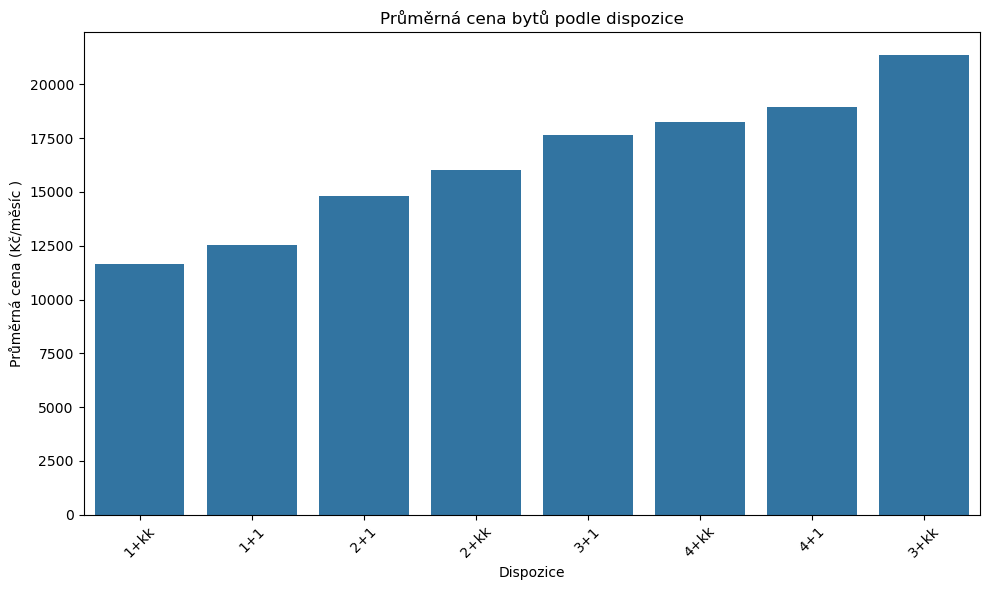

In [9]:
# průměrná cena bytů pro každou dispozici
prumerna_cena_dispozice = df_final.groupby("dispozice")["cena"].mean().sort_values()
print("\nPrůměrná cena bytů podle dispozice:")
print(prumerna_cena_dispozice)
# + graf
plt.figure(figsize=(10, 6))
sns.barplot(x=prumerna_cena_dispozice.index, y=prumerna_cena_dispozice.values)
plt.title("Průměrná cena bytů podle dispozice")
plt.xlabel("Dispozice")
plt.ylabel("Průměrná cena (Kč/měsíc )")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Průměrná velikost bytu + graf



Průměrná velikost bytu podle dispozice:
dispozice
1+kk    32.745098
1+1     37.000000
2+kk    55.673913
2+1     61.200000
3+1     71.000000
3+kk    87.692308
4+1     91.666667
4+kk    92.500000
Name: rozmer, dtype: float64


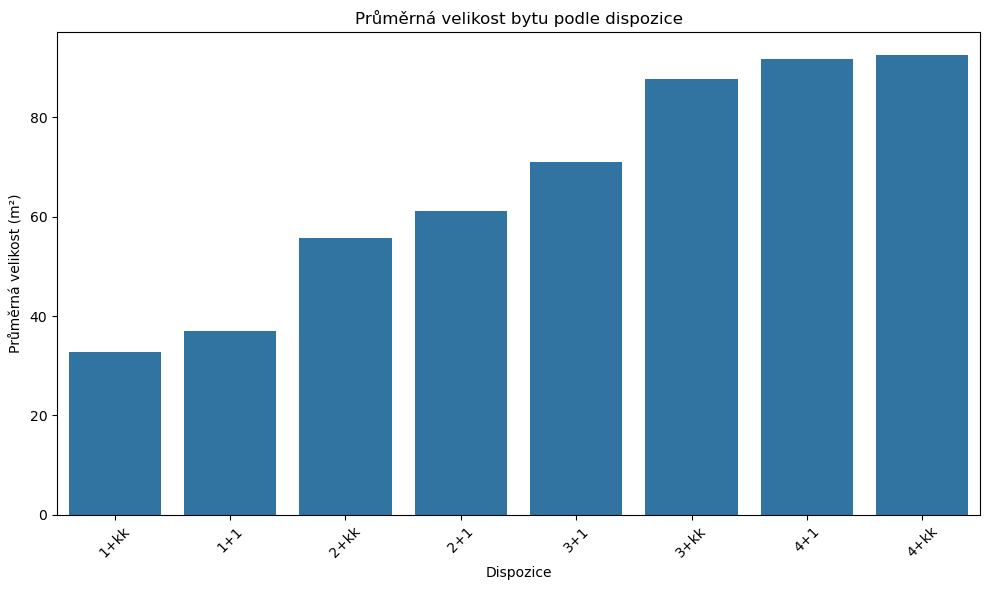

In [10]:
# průměrná velikost bytu za každou dispozici
prumerna_velikost_dispozice = (
    df_final.groupby("dispozice")["rozmer"].mean().sort_values()
)
print("\nPrůměrná velikost bytu podle dispozice:")
print(prumerna_velikost_dispozice)

# + graf
plt.figure(figsize=(10, 6))
sns.barplot(x=prumerna_velikost_dispozice.index, y=prumerna_velikost_dispozice.values)
plt.title("Průměrná velikost bytu podle dispozice")
plt.xlabel("Dispozice")
plt.ylabel("Průměrná velikost (m²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Ulice s vyšší koncentrací dražších bytů


In [11]:
df4 = df_final.copy()

# pro jistotu vyhodím řádky bez ulice
df4 = df4.dropna(subset=["Ulice"])

# průměrná cena bytu (celkově)
prumer_cena_bytu = df4["cena"].mean()

# průměr + počet bytů na ulici
top_ulice = (
    df4.groupby("Ulice")["cena"]
    .agg(prumerna_cena="mean", pocet_bytu="size")
    .reset_index()
)

# vezmu jen ulice, kde je průměr nad celkovým průměrem
top_ulice = top_ulice[top_ulice["prumerna_cena"] > prumer_cena_bytu]

# Zjistil jsem, ze některé ulice mají pouze 1 nebo 2 byty, což může zkreslovat analýzu.
# Proto vezmu jen ulice, kde je počet bytů alespoň 3
top_ulice = top_ulice[top_ulice["pocet_bytu"] >= 3]

# top 5 podle průměrné ceny
top_ulice = top_ulice.sort_values("prumerna_cena", ascending=False).head(5)

print(top_ulice)

         Ulice  prumerna_cena  pocet_bytu
49      Mostní   23333.333333           3
16    Díly III   21100.000000           4
43  Masarykova   20333.333333           3
63     Pančava   17000.000000           3
81   Smetanova   16880.000000           5


### Nejčastější dispozice


Nejčastější dispozice: 1+kk s počtem 51 bytů.


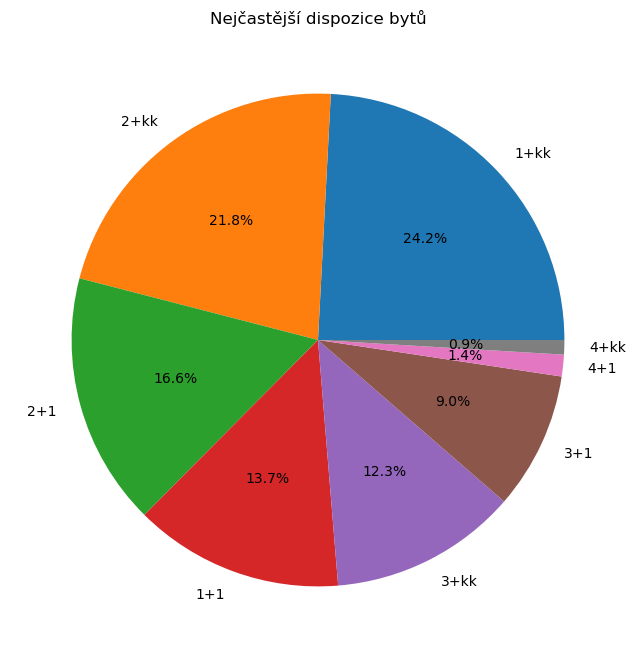

Je vidět, že nejčastější dispozice je 1+kk. Myslím si, že je to kvůli tomu, že jsou levnější a více lidí si je může dovolit.
Spousta lidí moc neplánuje rodinu nebo si nehledá partnera, takže jim stačí menší byt.


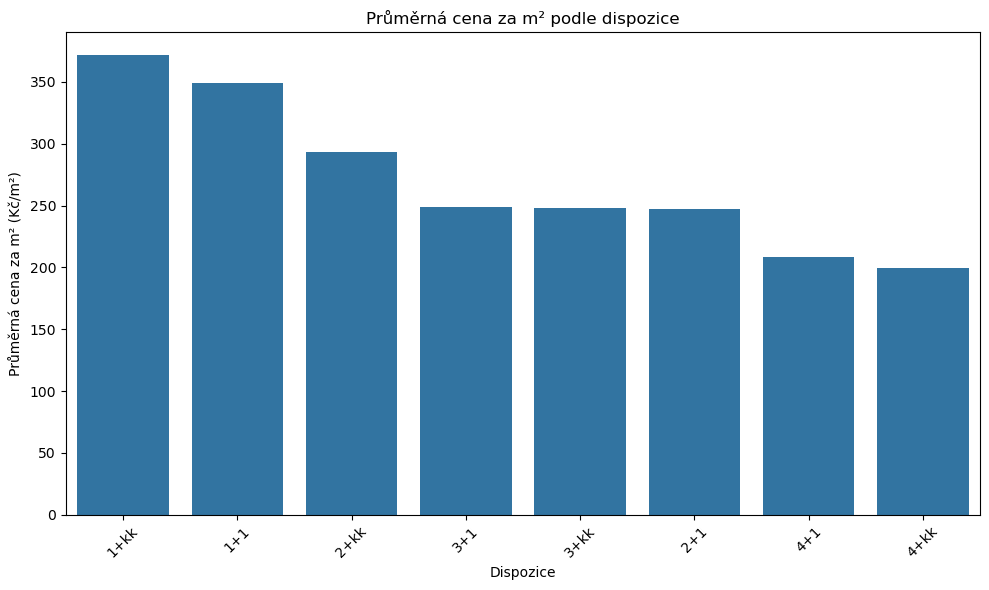

Z grafu je vidět, že ceny 1+kk nebo 1+1 jsou nejvyšší na metr čtvereční.
Takže je to i dobrá investice pro lidi, kteří plánují koupit byt na pronájem.
Jelikož vstupní náklady nejsou tak vysoké (jednopokojový byt je obecně levnější než vícepokojový), ale nájemné je relativně vysoké.


In [12]:
# nejčastější dispozice + graf
nejcastejsi_dispozice = df_final["dispozice"].value_counts()
print(
    "\nNejčastější dispozice: "
    + nejcastejsi_dispozice.index[0]
    + " s počtem "
    + str(nejcastejsi_dispozice.iloc[0])
    + " bytů."
)

# pie graf - podíl dispozic v %
ax = nejcastejsi_dispozice.plot(
    kind="pie",
    autopct="%.1f%%",
    figsize=(8, 8),
    title="Nejčastější dispozice bytů",
)

ax.set_ylabel("")  # odstraní popisek "count" vlevo

plt.show()

print(
    "Je vidět, že nejčastější dispozice je 1+kk. Myslím si, že je to kvůli tomu, že jsou levnější a více lidí si je může dovolit."
)
print(
    "Spousta lidí moc neplánuje rodinu nebo si nehledá partnera, takže jim stačí menší byt."
)

# Vypočítám kolik korun připadá na metr čtvereční pro každou dispozici
df_final["cena_za_m2"] = df_final["cena"] / df_final["rozmer"]
prumer_cena_m2_dispozice = (
    df_final.groupby("dispozice")["cena_za_m2"].mean().sort_values(ascending=False)
)

# + graf
plt.figure(figsize=(10, 6))
sns.barplot(x=prumer_cena_m2_dispozice.index, y=prumer_cena_m2_dispozice.values)
plt.title("Průměrná cena za m² podle dispozice")
plt.xlabel("Dispozice")
plt.ylabel("Průměrná cena za m² (Kč/m²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Z grafu je vidět, že ceny 1+kk nebo 1+1 jsou nejvyšší na metr čtvereční.")
print("Takže je to i dobrá investice pro lidi, kteří plánují koupit byt na pronájem.")
print(
    "Jelikož vstupní náklady nejsou tak vysoké (jednopokojový byt je obecně levnější než vícepokojový), ale nájemné je relativně vysoké."
)

### Inzerce bytů, které stojí více než 20k a jsou max dvoupokojvé

In [13]:
# kolik bytů stojí více než 20k s rozdělením podle dispozice
byty_nad_20k = df_final[df_final["cena"] > 20000]
print("Počet bytů nad 20k/měs. podle dispozice:\n")
pocet_byty_nad_20k = (
    byty_nad_20k["dispozice"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "dispozice", "dispozice": "dospozice"})
)

print(pocet_byty_nad_20k)


# byty nad 20k, které jsou max. dvoupokojové (1+kk, 1+1, 2+kk, 2+1)
dvoupokojove_typy = ["1+kk", "1+1", "2+kk", "2+1"]

# pouziji filtraci pomocí isin(), abych vybral pouze ty dispozice, které jsou v seznamu dvoupokojove_typy
byty_nad_20k_max2 = byty_nad_20k[byty_nad_20k["dispozice"].isin(dvoupokojove_typy)]

pocet_max2 = byty_nad_20k_max2.shape[0]
print(f"\nPočet max. dvoupokojových bytů nad 20k/měs. je: {pocet_max2}")

# takže skutečně jsou byty, které jsou max 2 pokojové a pronajímají se s více než 20k

Počet bytů nad 20k/měs. podle dispozice:

  dospozice  count
0      3+kk     13
1       3+1      4
2      2+kk      2
3       2+1      1

Počet max. dvoupokojových bytů nad 20k/měs. je: 3


### Minimální a maximální cena inzerce



Minimální a maximální cena inzerce podle dispozice:

             min    max
dispozice              
1+1         9500  16500
1+kk        7900  14900
2+1        11000  20500
2+kk        9500  25000
3+1        12500  26000
3+kk       12500  33000
4+1        17000  20000
4+kk       17500  19000

Dispozice s největším rozpětím cen:

dispozice
3+kk    20500
2+kk    15500
3+1     13500
2+1      9500
1+1      7000
1+kk     7000
4+1      3000
4+kk     1500
Name: cena, dtype: int64


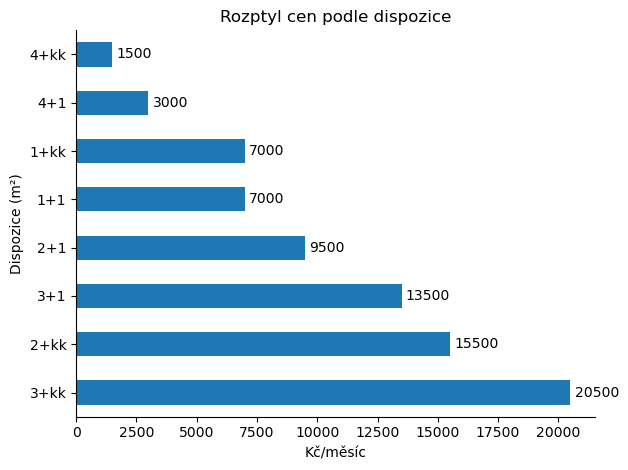

Byt s dispozicí 3+kk má největší rozdíl mezi nejnižší a nejvyšší cenou, a to 20500 Kč.


In [14]:
# Minimální a maximální cena inzerce pro každou dispozici
# Zjistíme, jaké jsou cenové rozpětí pro jednotlivé typy bytů podle dispozice pomocí agregace
min_max_cena_dispozice = df_final.groupby("dispozice")["cena"].agg(["min", "max"])

print("\nMinimální a maximální cena inzerce podle dispozice:\n")
print(min_max_cena_dispozice)


# tady si jen spočítám rozdíl mezi nejnižší a nejvyšší cenou u každé dispozice
# chci vidět, kde je největší rozpětí cen

rozpeti = (
    df_final.groupby("dispozice")["cena"].max()
    - df_final.groupby("dispozice")["cena"].min()
)
rozpeti = rozpeti.sort_values(ascending=False)

print("\nDispozice s největším rozpětím cen:\n")
print(rozpeti)


# graf
rozpeti = rozpeti.sort_values(ascending=False)

ax = rozpeti.plot(kind="barh", title="Rozptyl cen podle dispozice")
ax.set_xlabel("Kč/měsíc")
ax.set_ylabel("Dispozice (m²)")

# doplním hodnoty přímo na sloupce (
ax.bar_label(ax.containers[0], fmt="%.0f", padding=3)

# schovám horní a pravý okraj grafu, protože mi cena u 3+kk přečuhovala
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

# Vypíšu jaký byt má největší rozdíl mezi nejnižší a nejvyšší cenou
nejvetsi_rozpeti_dispozice = rozpeti.index[0]
nejvetsi_rozpeti_hodnota = rozpeti.iloc[0]
print(
    f"Byt s dispozicí {nejvetsi_rozpeti_dispozice} má největší rozdíl mezi nejnižší a nejvyšší cenou, a to {nejvetsi_rozpeti_hodnota} Kč."
)

## BONUS

**Zkoumání a hledání nejlepší nabídky co se týče poměru cena/m2 u 3+kk**

Při rozhodování nejsou řešeny další aspekty jako stav bytu, vybavení, lokalita atd.

In [20]:
# zkontroluji zda skutečně byt 3+kk může mít tak velké rozpětí cen
# vypíšu si všechny byty s dispozicí 3+kk
byty_3kk = df_final[df_final["dispozice"] == "3+kk"].copy()
byty_3kk = byty_3kk.sort_values("cena", ascending=False)
print("\nByty s dispozicí 3+kk seřazené podle ceny:\n")

# zobrazím si přehledně v tabulce sloupce, které mě zajímají
byty_3kk_display = byty_3kk[["url", "rozmer", "cena"]]
display(byty_3kk_display)

# Seřadím to podle rozměru
byty_3kk_sorted_rozmer = byty_3kk.sort_values("rozmer", ascending=False)
print("\nByty s dispozicí 3+kk seřazené podle rozměru:\n")
display(byty_3kk_sorted_rozmer[["url", "rozmer", "cena"]])


Byty s dispozicí 3+kk seřazené podle ceny:



,url,rozmer,cena
208,https://www.sreality.cz/detail/pronajem/byt/3+...,143,33000
73,https://www.sreality.cz/detail/pronajem/byt/3+...,92,30700
51,https://www.sreality.cz/detail/pronajem/byt/3+...,100,30000
52,https://www.sreality.cz/detail/pronajem/byt/3+...,119,29000
69,https://www.sreality.cz/detail/pronajem/byt/3+...,82,25000
182,https://www.sreality.cz/detail/pronajem/byt/3+...,94,25000
126,https://www.sreality.cz/detail/pronajem/byt/3+...,86,23000
199,https://www.sreality.cz/detail/pronajem/byt/3+...,83,22900
196,https://www.sreality.cz/detail/pronajem/byt/3+...,73,22000
187,https://www.sreality.cz/detail/pronajem/byt/3+...,70,22000



Byty s dispozicí 3+kk seřazené podle rozměru:



,url,rozmer,cena
208,https://www.sreality.cz/detail/pronajem/byt/3+...,143,33000
52,https://www.sreality.cz/detail/pronajem/byt/3+...,119,29000
25,https://www.sreality.cz/detail/pronajem/byt/3+...,110,20000
49,https://www.sreality.cz/detail/pronajem/byt/3+...,105,16500
33,https://www.sreality.cz/detail/pronajem/byt/3+...,100,16000
51,https://www.sreality.cz/detail/pronajem/byt/3+...,100,30000
6,https://www.sreality.cz/detail/pronajem/byt/3+...,100,18000
145,https://www.sreality.cz/detail/pronajem/byt/3+...,96,20000
182,https://www.sreality.cz/detail/pronajem/byt/3+...,94,25000
73,https://www.sreality.cz/detail/pronajem/byt/3+...,92,30700


In [16]:
# rozdělím si 3+kk byty na tři skupiny podle rozměrů například 41-50, 51-60, 61-70...
# chci si tímto ověřit, jak moc cena závisí na velikosti bytu
# z tabulky vyše je vidět, že nejnižší cenu drží byt 75m² a to 12500 Kč/měs.
# chci tímto zjistit, jak moc daný byty se svojí cenou vybočují z průměru ve své velikostní kategorii

from IPython.display import HTML, display

# udelam kopii (abych si nerozbil puvodni tabulku)
byty_3kk_size_price = byty_3kk_display.copy()


# funkce pro zarazeni do velikostni kategorie (do 150 m2)
def velikostni_kategorie(rozmer):
    if rozmer <= 50:
        return "41-50"
    elif rozmer <= 60:
        return "51-60"
    elif rozmer <= 70:
        return "61-70"
    elif rozmer <= 80:
        return "71-80"
    elif rozmer <= 90:
        return "81-90"
    elif rozmer <= 100:
        return "91-100"
    elif rozmer <= 110:
        return "101-110"
    elif rozmer <= 120:
        return "111-120"
    elif rozmer <= 130:
        return "121-130"
    elif rozmer <= 140:
        return "131-140"
    else:
        return "141-150"


# priradim kazdemu bytu velikostni kategorii podle rozmeru
byty_3kk_size_price["velikostni_kategorie"] = byty_3kk_size_price["rozmer"].apply(
    velikostni_kategorie
)

# spocitam prumernou cenu + pocet bytu v kazde velikostni kategorii
prumerna_cena_velikost = (
    byty_3kk_size_price.groupby("velikostni_kategorie")["cena"]
    .agg(cena_prumer="mean", pocet_bytu="size")
    .round({"cena_prumer": 0})
    .reset_index()
)

# pripojim prumernou cenu zpet k bytum (abych mohl spocitat rozdil)
byty_3kk_size_price = byty_3kk_size_price.merge(
    prumerna_cena_velikost, on="velikostni_kategorie", how="left"
)

# rozdil = cena bytu - prumer v jeho kategorii
byty_3kk_size_price["rozdil_od_prumeru"] = (
    byty_3kk_size_price["cena"] - byty_3kk_size_price["cena_prumer"]
)

# seradim podle nejvetsi odchylky
byty_3kk_final = byty_3kk_size_price.sort_values(
    "rozdil_od_prumeru", ascending=False
).copy()

# udelam url klikaci az uplne na konci (jinak se to rozbije pri merge/sort)
byty_3kk_final["url"] = byty_3kk_final["url"].apply(
    lambda x: f'<a href="{x}" target="_blank">Otevřít v prohlížeči</a>'
)

display(
    HTML(
        byty_3kk_final[
            [
                "url",
                "rozmer",
                "cena",
                "velikostni_kategorie",
                "cena_prumer",
                "rozdil_od_prumeru",
                "pocet_bytu",
            ]
        ].to_html(escape=False, index=False)
    )
)

# vytvořím tabulku abych zjistil, kolik bytů je v každé velikostní kategorii
tab_kategorie_pocet = (
    byty_3kk_final["velikostni_kategorie"]
    .value_counts()
    .rename_axis("velikostni_kategorie")
    .reset_index(name="pocet_bytu")
    .sort_values("velikostni_kategorie")
)

display(tab_kategorie_pocet)

# Z tabulky jsem zjistil, že se tam můžou nacházet i velikostní kategorie, kde je pouze jeden byt.
# vypíšu o jaké kategorie se jedná
kategorie_s_jednim_bytem = tab_kategorie_pocet[tab_kategorie_pocet["pocet_bytu"] == 1][
    "velikostni_kategorie"
].tolist()
print(
    "Velikostní kategorie s pouze jedním bytem: " + ", ".join(kategorie_s_jednim_bytem)
)
print("S těmito kategoriemi později nebudu počítat.")

url,rozmer,cena,velikostni_kategorie,cena_prumer,rozdil_od_prumeru,pocet_bytu
Otevřít v prohlížeči,92,30700,91-100,23283.0,7417.0,6
Otevřít v prohlížeči,100,30000,91-100,23283.0,6717.0,6
Otevřít v prohlížeči,82,25000,81-90,21050.0,3950.0,6
Otevřít v prohlížeči,73,22000,71-80,18583.0,3417.0,6
Otevřít v prohlížeči,72,22000,71-80,18583.0,3417.0,6
Otevřít v prohlížeči,86,23000,81-90,21050.0,1950.0,6
Otevřít v prohlížeči,83,22900,81-90,21050.0,1850.0,6
Otevřít v prohlížeči,110,20000,101-110,18250.0,1750.0,2
Otevřít v prohlížeči,94,25000,91-100,23283.0,1717.0,6
Otevřít v prohlížeči,78,20000,71-80,18583.0,1417.0,6


,velikostni_kategorie,pocet_bytu
4,101-110,2
6,111-120,1
5,141-150,1
7,51-60,1
3,61-70,3
2,71-80,6
1,81-90,6
0,91-100,6


Velikostní kategorie s pouze jedním bytem: 111-120, 141-150, 51-60
S těmito kategoriemi později nebudu počítat.


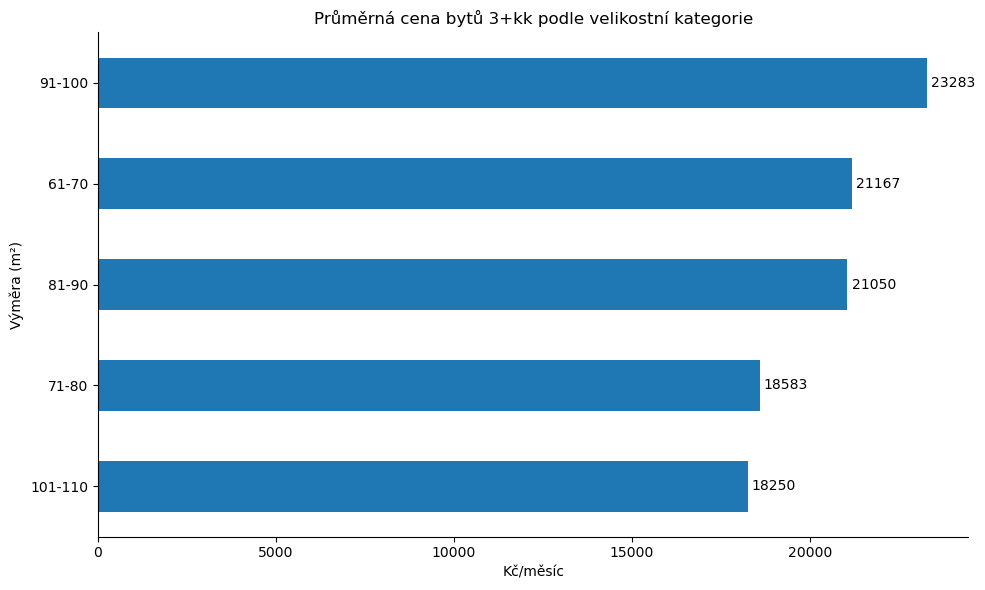

Z grafu je vidět, že dispozice může mít vliv na cenu bytu ale není jediný faktor.
Nejvyšší průměrná cena je u kategorie 91-100 s cenou 23283.0 Kč/měsíc.
Nejnižší průměrná cena je u kategorie 101-110 s cenou 18250.0 Kč/měsíc.
Může to být způsobeno lokalitou, stavem, nebo vybavením bytu (příslušenstvím).


In [25]:
# vyřadím z tabulky řádky, kde je v dané katetegorii pouze jeden byt (nemá smysl porovnávat s průměrem)

# Vytvořím kopii pro filtrování
byty_3kk_filtered = byty_3kk_final.copy()

# Vyfiltruji řádky: ponechám jen ty, jejichž kategorie NENÍ v seznamu k vyřazení
# Používám ~ jako negaci
byty_3kk_filtered = byty_3kk_filtered[
    ~byty_3kk_filtered["velikostni_kategorie"].isin(kategorie_s_jednim_bytem)
]

# Reset indexu pro pořádek
byty_3kk_filtered = byty_3kk_filtered.reset_index(drop=True)

# Kontrola - zobrazím počet řádků před a po
# print(f"Původní počet řádků: {len(byty_3kk_final)}")
# print(f"Počet řádků po filtraci: {len(byty_3kk_filtered)}")
# Zobrazím unikátní kategorie po filtraci pro ověření
# print("Zbylé kategorie:", byty_3kk_filtered["velikostni_kategorie"].unique())

# udelam graf kde porovnam prumerne ceny podle velikostni kategorie
prumer_kat = (
    byty_3kk_filtered.groupby("velikostni_kategorie")["cena"]
    .mean()
    .round()
    .sort_values(ascending=True)
)

ax = prumer_kat.plot(kind="barh", figsize=(10, 6))
plt.title("Průměrná cena bytů 3+kk podle velikostní kategorie")
plt.xlabel("Kč/měsíc")
plt.ylabel("Výměra (m²)")
plt.xticks(rotation=0)

# doplním hodnoty přímo na sloupce (
ax.bar_label(ax.containers[0], fmt="%.0f", padding=3)

# schovám horní a pravý okraj grafu, protože mi cena u 3+kk přečuhovala
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

print(
    "Z grafu je vidět, že dispozice může mít vliv na cenu bytu ale není jediný faktor."
)
# Vypíšu jaká dispozice má nejvyšší průměrnou cenu
nejdrazsi_kategorie = prumer_kat.idxmax()
nejdrazsi_cena = prumer_kat.max()
print(
    f"Nejvyšší průměrná cena je u kategorie {nejdrazsi_kategorie} s cenou {nejdrazsi_cena} Kč/měsíc."
)

# Vypíšu jaká dispozice má nejnižší průměrnou cenu
nejlevnejsi_kategorie = prumer_kat.idxmin()
nejlevnejsi_cena = prumer_kat.min()
print(
    f"Nejnižší průměrná cena je u kategorie {nejlevnejsi_kategorie} s cenou {nejlevnejsi_cena} Kč/měsíc."
)

print("Může to být způsobeno lokalitou, stavem, nebo vybavením bytu (příslušenstvím).")

Počet bytů 3+kk, které jsou pod průměrnou cenou ve své velikostní kategorii: 9 z celkového počtu 26.


url,rozmer,cena,velikostni_kategorie,cena_prumer,rozdil_od_prumeru
Otevřít v prohlížeči,65,20000,61-70,21167.0,-1167.0
Otevřít v prohlížeči,105,16500,101-110,18250.0,-1750.0
Otevřít v prohlížeči,75,16000,71-80,18583.0,-2583.0
Otevřít v prohlížeči,96,20000,91-100,23283.0,-3283.0
Otevřít v prohlížeči,90,17500,81-90,21050.0,-3550.0
Otevřít v prohlížeči,90,15900,81-90,21050.0,-5150.0
Otevřít v prohlížeči,100,18000,91-100,23283.0,-5283.0
Otevřít v prohlížeči,75,12500,71-80,18583.0,-6083.0
Otevřít v prohlížeči,100,16000,91-100,23283.0,-7283.0


Z tabulky je vidět, že byt o rozměru 100m² vybočuje nejvíce z průměru ve své velikostní kategorii.
Na první pohled se může zdát, že je to výhodná nabídka, ale je třeba zvážit další faktory.
Například lokalitu, stav bytu, vybavení, a další aspekty, které mohou ovlivnit celkovou hodnotu nabídky.
Určitě tato analýza může sloužit jako výchozí bod pro další zkoumání a rozhodování při výběru bytu k pronájmu.


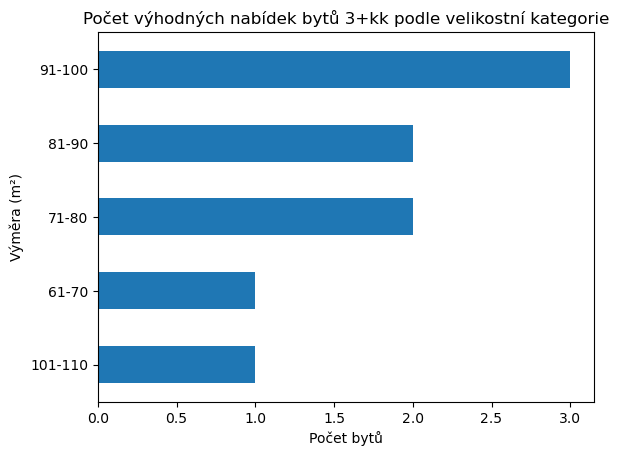

Nejvíce výhodných nabídek je v kategorii 91-100 s počtem 3 bytů.


In [24]:
# jako další krok vypíšu pro uživatele hezky do tabulky byty 3+kk, které jsou nabízeny_
# _pod průměrnou cenou v jejich velikostní kategorii
# Pokud někdo chce "hodně muziky za málo peněz", může se podívat na následující tabulku
byty_3kk_pod_prumerem = byty_3kk_final[byty_3kk_final["rozdil_od_prumeru"] < 0].copy()

# Vypíšu kolik bytů je pod průměrnou cenou z celkvého počtu bytů 3+kk
pocet_vyhodnych_bytu = byty_3kk_pod_prumerem.shape[0]
celkovy_pocet_bytu_3kk = byty_3kk_final.shape[0]
print(
    f"Počet bytů 3+kk, které jsou pod průměrnou cenou ve své velikostní kategorii: {pocet_vyhodnych_bytu} z celkového počtu {celkovy_pocet_bytu_3kk}."
)

# zobrazim jako HTML tabulku (klikaci odkazy)
display(
    HTML(
        byty_3kk_pod_prumerem[
            [
                "url",
                "rozmer",
                "cena",
                "velikostni_kategorie",
                "cena_prumer",
                "rozdil_od_prumeru",
            ]
        ].to_html(escape=False, index=False)
    )
)

print(
    "Z tabulky je vidět, že byt o rozměru 100m² vybočuje nejvíce z průměru ve své velikostní kategorii."
)
print(
    "Na první pohled se může zdát, že je to výhodná nabídka, ale je třeba zvážit další faktory."
)
print(
    "Například lokalitu, stav bytu, vybavení, a další aspekty, které mohou ovlivnit celkovou hodnotu nabídky."
)
print(
    "Určitě tato analýza může sloužit jako výchozí bod pro další zkoumání a rozhodování při výběru bytu k pronájmu."
)

# + Graf, kde je nejvíce výhodných nabídek (počet bytů pod průměrnou cenou) podle velikostní kategorie
byty_vyhoda_kategorie = (
    byty_3kk_pod_prumerem["velikostni_kategorie"]
    .value_counts()
    .rename_axis("velikostni_kategorie")
    .reset_index(name="pocet_vyhodnych_bytu")
    .sort_values("velikostni_kategorie")
)
ax = byty_vyhoda_kategorie.plot(
    kind="barh", x="velikostni_kategorie", y="pocet_vyhodnych_bytu", legend=False
)
plt.title("Počet výhodných nabídek bytů 3+kk podle velikostní kategorie")
plt.xlabel("Počet bytů")
plt.ylabel("Výměra (m²)")
plt.show()

# Intuitivně vypíšu, kde je nejvíce výhodných nabídek
# najdu řádek s maximálním počtem výhodných bytů
max_vyhodnych = byty_vyhoda_kategorie.loc[
    byty_vyhoda_kategorie["pocet_vyhodnych_bytu"].idxmax()
]
# vypíšu kategorii a počet
kategorie = max_vyhodnych["velikostni_kategorie"]
pocet = max_vyhodnych["pocet_vyhodnych_bytu"]
print(f"Nejvíce výhodných nabídek je v kategorii {kategorie} s počtem {pocet} bytů.")